# CS 444: Deep Learning for Computer Vision, Fall 2024, Assignment 5

Assignment is due at 11:59:59 PM on Thursday Dec 5 2024.

1. Assignment is due at **11:59:59 PM on Thursday Dec 5 2024**.

2. See [policies](https://saurabhg.web.illinois.edu/teaching/cs444/fa2024/policies.html) on [class website](https://saurabhg.web.illinois.edu/teaching/cs444/fa2024).

3. Submission instructions:
    1. On gradescope assignment called `MP5-code`, upload the following  files:
        - Your completed `vae.py`, `score.py`, `networks.py`, and `train_mnist.py` files.

       Please also note the following points:
        - Do not compress the files into `.zip` as this will not work.
        - Do not change the provided files names nor the names of the functions but rather change the code inside the provided functions and add new functions. Also, make sure that the inputs and outputs of the provided functions are not changed.
        - The autograder will give you feedback on how well your code did for the autograded parts.
        - The autograder is configured with the python libraries: `numpy matplotlib tqdm torch` only.

4. Lastly, be careful not to work of a public fork of this repo. Make a private clone to work on your assignment. You are responsible for preventing other students from copying your work.

In this notebook, we will implement the VAEs and Score Matching ([Noise-Conditioned Score Network](https://arxiv.org/abs/1907.05600)) models and compare their performance on the swiss roll dataset. We will also use NCSNs to generate MNIST images.

## Workflow

1. To start, you will implement the network architectures defined in `vae.py` and `score.py`. You can use this Jupyter Notebook for testing your implementation and visualizing your results. You don't need a serious GPU for Q1 and Q2.
    1. To facilitate your testing, enable the autoreload extension so that your modifications to the `.py` files will be automatically reloaded. In our testing, we found this to be somewhat finicky and had to restart the kernel for it to pickup the changed files for some parts.
    
2. One you successfully finish the score-matching parts, you are ready to tackle Q3 where you will be training a NCSN network to generate MNIST digits. This may need a good GPU and you are welcome to use the CampusCluster or Google Colab or Kaggle.

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
import unittest
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from vae import VAE
from score import ScoreNet
from networks import SimpleDecoder, SimpleEncoder

### Swiss Roll Dataset

In [4]:
def make_swiss_roll(n_samples=100, *, noise=0.0, seed=None):
    generator = torch.Generator()
    generator.manual_seed(seed)
    t = 1.5 * np.pi * (1 + 2 * torch.rand(n_samples, generator=generator))
    x = t * torch.cos(t)
    y = t * torch.sin(t)

    X = torch.stack((x, y), dim=1)
    X += noise * torch.randn(n_samples, 2, generator=generator)
    return X, t

def count_parameters(model):
    return sum(p.numel() for p in model.parameters())

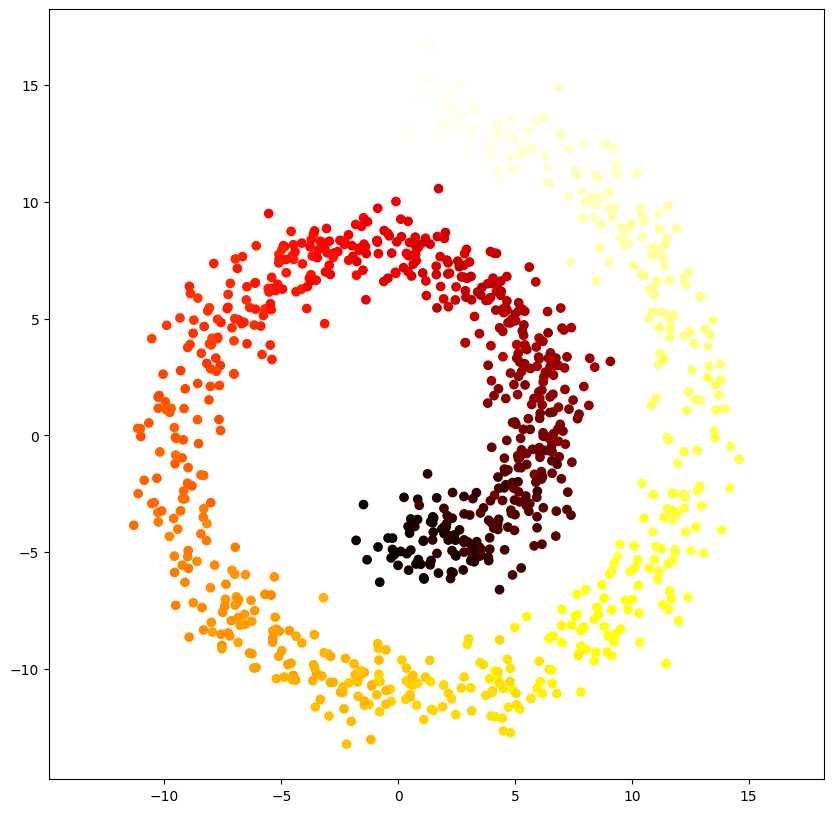

In [5]:
X, t = make_swiss_roll(n_samples=1000, noise=1., seed=42)
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.axis('equal')
plt.show()

## Q1. VAE (Swiss Roll)

**Q1.1 [1 pts Autograded]** Implement the `reparameterize` method in `vae.py`. This method takes in the mean and log-variance of the latent distribution and returns a sample from the distribution.

Once you have implemented the method, run the following cell to test your implementation.

In [6]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_vae_reparam')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.376s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

**Q1.2 [3 pts Autograded]** Implement the `get_loss` method in `vae.py`. This method takes in a batch of data and returns the VAE loss. You should compute the reconstruction loss and the KL divergence loss and return the sum of the two losses. The reconstruction loss is the **mean squared error** between the reconstructed images and the original images. The KL divergence loss can be computed in closed form, and you should **sum** it along latent dimensions.

**Hint**. The KL-divergence between a Gaussian distribution with mean $\mu$ and variance $\sigma^2$ and a standard Gaussian distribution $\mathcal{N}(0,1)$ is given by:

$$
\mathcal{D}_{\text{KL}}(\mathcal{N}(\mu, \sigma^2) || \mathcal{N}(0, 1)) = \frac{1}{2}\left( \sigma^2 + \mu^2 - 1 - \log \sigma^2 \right)
$$

Once you have implemented the method, run the following cell to test your implementation.

In [7]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_vae_loss')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.056s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

Now train your VAE model on the Swiss roll dataset and try to generate some points after training.

In [8]:
vae = VAE(
    SimpleEncoder(input_size=2, hidden_size=128, latent_size=10 * 2),
    SimpleDecoder(latent_size=10, hidden_size=128, output_size=2)
)
print(f'Number of parameters in VAE: {count_parameters(vae)}')
vae.train()

optimizer = optim.Adam(vae.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = vae.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')

Number of parameters in VAE: 37654
Epoch 0, loss 51.7266
Epoch 200, loss 6.1207
Epoch 400, loss 4.7999
Epoch 600, loss 4.7079
Epoch 800, loss 4.8015
Epoch 1000, loss 4.7088
Epoch 1200, loss 4.6852
Epoch 1400, loss 4.7087
Epoch 1600, loss 4.6569
Epoch 1800, loss 4.6766
Done!


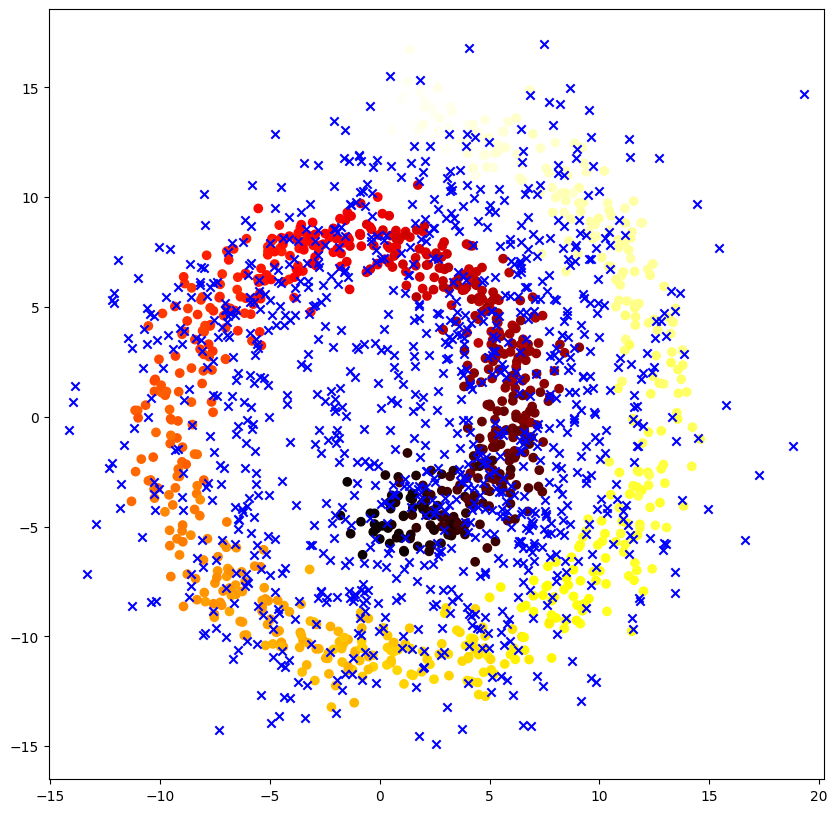

In [9]:
n_sample = 1000
vae.eval()
with torch.no_grad():
    X_gen = vae.sample(n_sample, 'cpu')
plt.figure(figsize=(10, 10))
plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
plt.axis('equal')
plt.show()

## Q2: Score Matching (Swiss Roll)

In this part, you are expected to implement the score matching model on the Swiss roll dataset.

**Q2.1 [2 pts Autograded]** Implement the `perturb` method in `score.py`. This function takes in a batch of data and returns a perturbed batch of data. Specifically, you should first choose uniformly random from `self.simgas` for each data (NOT each pixel/coordinate!). Then add the Gaussian noise the data with standard deviation `sigma`. Return the applied noise and used sigma values. DO NOT clip the perturbed data!

Once you have implemented the method, run the following cell to test your implementation.

In [10]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_perturb')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.572s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

**Q2.2 [3 pts Autograded]** Implement the `get_loss` method in `score.py`. You should first call `perturb` to obtain the noise and perturbed data and call `get_score` to obtain the estimated scores for the perturbed data. The score loss in NCSNv2 is defined as:

$$
\mathcal{L}_{\text{score}} = \frac{1}{2}\mathbb{E}_{\sigma} \mathbb{E}_{\hat{\mathbf{x}}\sim p(\mathbf{\hat{x}},\mathbf{x})} \left[ \left( s(\hat{\mathbf{x}}) - \frac{\mathbf{x} - \mathbf{\hat{x}}}{\sigma^2} \right)^2\cdot \sigma^2 \right]
$$

where $\mathbf{x}$ is the original data and $\mathbf{\hat{x}}$ is the perturbed data. $\sigma$ is the standard deviation of the noise, and $s(\hat{\mathbf{x}})$ is the estimated score for the perturbed data. The loss should be **averaged** over the batch dimension and the image dimensions.

Once you have implemented the method, run the following cell to test your implementation.

In [11]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_loss')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.369s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

**Q2.3 [2 pts Autograded]** Complete the `sample` method in `score.py`. Recall that in Langevin dynamics, the update rule is:

$$
\mathbf{x}_{t+1} = \mathbf{x}_t + \eta\nabla_{\mathbf{x}}\log p(\mathbf{x}) + \sqrt{2\eta}\mathbf{z}_t
$$

where $\mathbf{z}_t\sim \mathcal{N}(0, \mathbf{I})$. In this method, we first sample a batch of noise $\mathbf{z}_t$ and estimate the scores (gradient of the log density $\nabla_{\mathbf{x}}\log p(\mathbf{x})$) using `get_score`. Then you should compute the update $\mathbf{x}_{t+1}$ and return the sequence of updates.

Once you have implemented the method, run the following cell to test your implementation.


In [12]:
suite = unittest.TestLoader().loadTestsFromName('test_models.TestModels.test_score_sample')
unittest.TextTestRunner().run(suite)

.
----------------------------------------------------------------------
Ran 1 test in 0.043s

OK


<unittest.runner.TextTestResult run=1 errors=0 failures=0>

In [13]:
scorenet = ScoreNet(
    torch.nn.Sequential(
        SimpleEncoder(input_size=2, hidden_size=128, latent_size=16),
        SimpleDecoder(latent_size=16, hidden_size=128, output_size=2),
    ), 10., 0.1, 20, 'geometric'
)
scorenet.train()
optimizer = optim.Adam(scorenet.parameters(), lr=1e-3)
for epoch in range(2000):
    optimizer.zero_grad()
    loss = scorenet.get_loss(X)
    loss.backward()
    optimizer.step()
    if epoch % 200 == 0:
        print(f'Epoch {epoch}, loss {loss.item():.4f}')
print('Done!')

Epoch 0, loss 0.4985
Epoch 200, loss 0.4202
Epoch 400, loss 0.4418
Epoch 600, loss 0.4004
Epoch 800, loss 0.4060
Epoch 1000, loss 0.4220
Epoch 1200, loss 0.4095
Epoch 1400, loss 0.4145
Epoch 1600, loss 0.4119
Epoch 1800, loss 0.4128
Done!


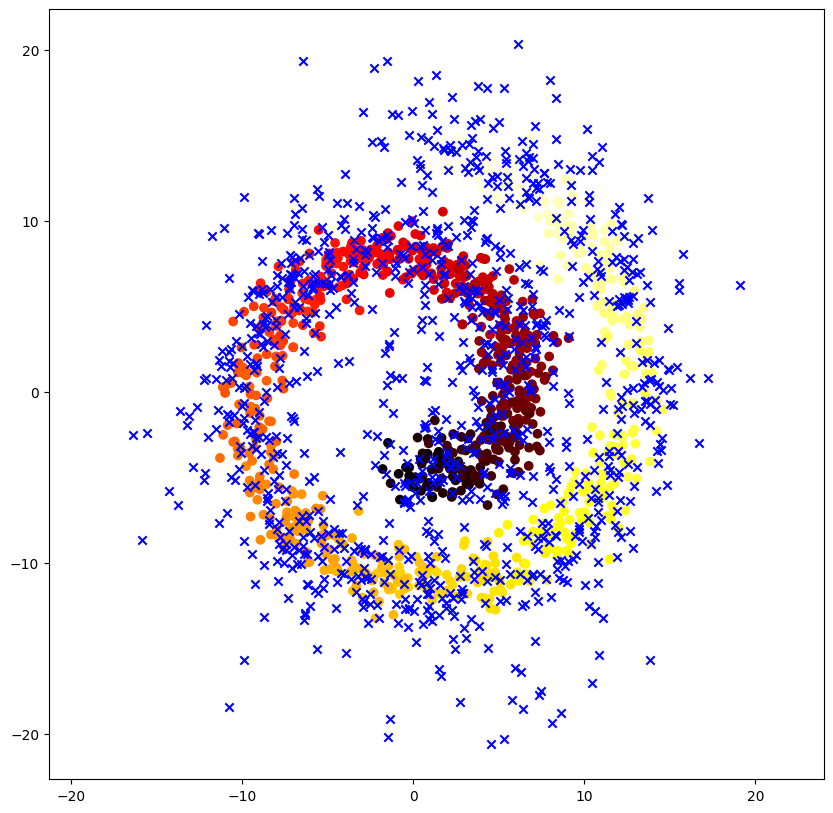

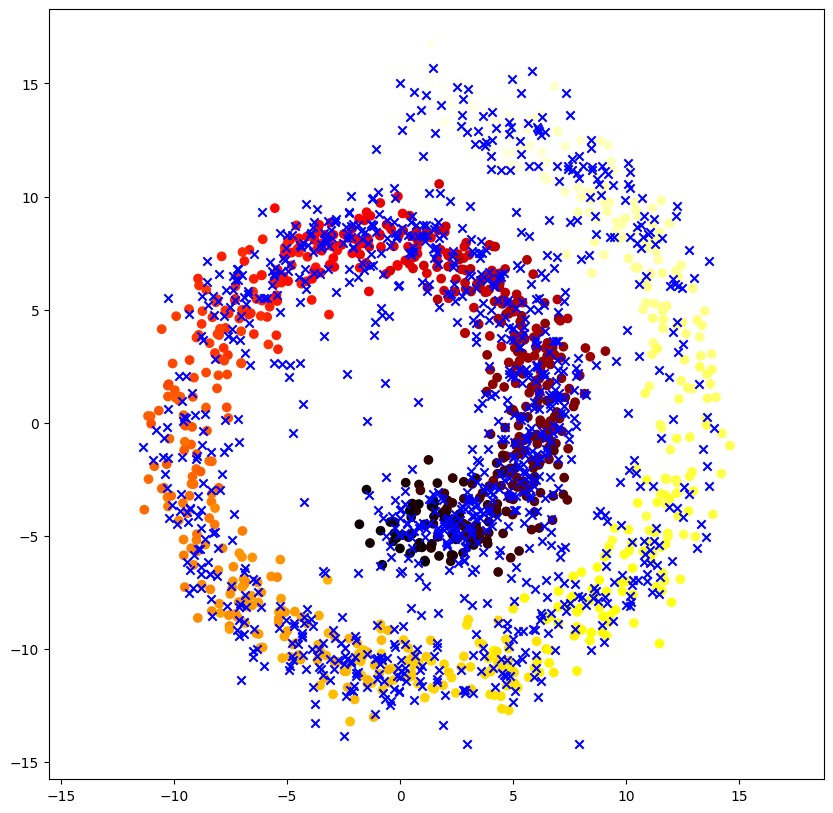

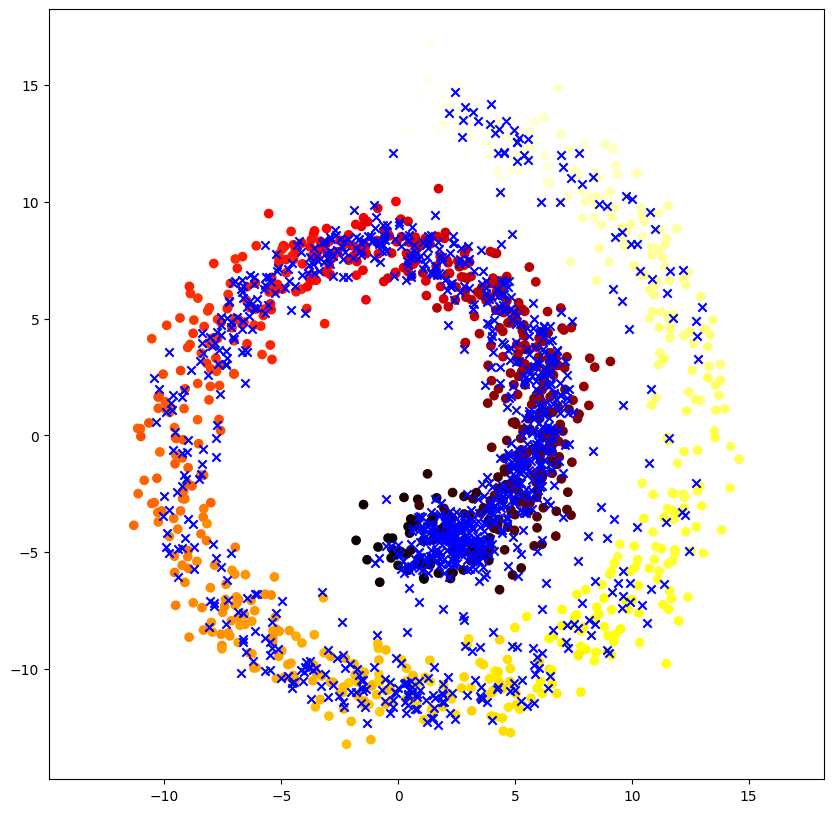

In [17]:
n_sample = 1000
scorenet.eval()

step_lr_list = [5e-4, 2e-3, 8e-3]

for lr_val in step_lr_list:
    with torch.no_grad():
        X_gen = scorenet.sample(n_sample, 2, step_lr=lr_val)[-1, -1]
    plt.figure(figsize=(10, 10))
    plt.scatter(X[:, 0], X[:, 1], c=t, cmap=plt.cm.hot)
    plt.scatter(X_gen[:, 0], X_gen[:, 1], c='b', marker='x')
    plt.axis('equal')
    plt.show()

**Q2.4 [1 pts Manual graded]** Compare the sampled points from VAE and score matching and upload the visualization. Which model do you think performs the best?

**Q2.5 [1 pts Manual graded]** Modify the `step_lr` argument in the score-matching sampling and rerun the sampling for at least three different step sizes. Upload the visualization and discuss the effect of the step size on the sampling.

## Q3: Score Matching (MNIST)

**Q3 [3 pts Manual graded]** Next, we will use Score Matching on the MNIST dataset to generate MNIST digits. An example implementation that only uses the SimpleEncoder and SimpleDecoder networks is provided in `train_mnist.py`. As provided, the network doesn't work and generated samples are of bad quality. Your task is to make it work such that it starts generating good samples. You might have to adjust the hyper-parameters and experiment with different networks. We found success with a UNet architecture. Note that the MNIST dataset here contains 32 x 32 images instead of the usual 28 x 28 images. This may simplify implementation of a UNet. Our implementation is able to generate reasonably looking samples in a few minutes of training on a 2080Ti GPU.

You can use following command to get started, though as noted, this doesn't produce good samples. It will store tensorboard logs (with samples) and also save generated samples as images.

```bash
CUDA_VISIBLE_DEVICES=1 python train_mnist.py --num_epochs 30 --model_type simple_fc --output_dir runs/fc-v1
```

You can also use the following command to launch the job on campuscluster:
```bash
sbatch --export=ALL,OUTPUT_DIR="runs/fc-v1/" --output="runs/fc-v1/%j.out" --error="runs/fc-v1/%j.err" sample.sbatch
```

Upload the samples generated by your best model, and describe the changes you had to make (architecture, hyper-parameters) to get these samples. Feel free to include samples from intermediate runs if useful.

In [ ]:
python train_mnist.py --num_epochs 60 --model_type unet --output_dir runs/unet-v5

sbatch --export=ALL,OUTPUT_DIR="runs/unet-v3/" --output="runs/unet-v3/%j.out" --error="runs/unet-v3/%j.err" sample.sbatch

squeue -u sshetye2

tail -f runs/unet-v3/log.txt
